<a href="https://colab.research.google.com/github/lharao/Data-analysis-Northwind/blob/main/Data_Analysis_Northwind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio Estágio Análise de Dados/Engenharia de Analytics - Northwind

###Contexto:
####A Northwind Traders é uma loja fictícia que gerencia pedidos, produtos, clientes, fornecedores e muitos outros aspectos de uma pequena empresa.
####Esta apresentação tem como objetivo fornecer uma visão abrangente das operações de vendas da Northwind, utilizando análises de dados detalhadas para identificar tendências, desempenho e áreas de melhoria.
###Metodologia
####Para alcançar esse objetivo, foram integrados dados de várias tabelas relacionadas, incluindo detalhes de pedidos, informações de clientes, produtos, funcionários e fornecedores. Através de técnicas de análise de dados, foram calculados indicadores-chave de desempenho (KPIs) e geradas visualizações que facilitam a compreensão dos resultados.
###Resultados e Insights
####Os resultados desta análise fornecem uma base sólida para a tomada de decisões estratégicas, permitindo-nos identificar áreas de alto desempenho e aquelas que necessitam de melhorias. Através dos insights gerados, podemos implementar ações direcionadas para otimizar nossos processos, melhorar a satisfação do cliente e aumentar a eficiência operacional.

####Os detalhes do raciocínio serão demonstrados no decorrer deste documento.



##1. Carregamento e limpeza de dados

###Primeiro, carregaremos todos os conjuntos de dados e limparemos os dados conforme necessário.


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

file_paths = {
    'shippers': '/content/shippers.csv',
    'region': '/content/region.csv',
    'products': '/content/products.csv',
    'order_details': '/content/order_details.csv',
    'employee_territories': '/content/employee_territories.csv',
    'employees': '/content/employees.csv',
    'customers': '/content/customers.csv',
    'customer_demographics': '/content/customer_demographics.csv',
    'customer_customer_demo': '/content/customer_customer_demo.csv',
    'categories': '/content/categories.csv',
    'orders': '/content/orders.csv',
    'us_states': '/content/us_states.csv',
    'territories': '/content/territories.csv',
    'suppliers': '/content/suppliers.csv'
}

dfs = {}
for key, path in file_paths.items():
    dfs[key] = pd.read_csv(path, delimiter=';')

for name, df in dfs.items():
    print(f"\n{name} DataFrame:")
    print(df.head(), "\n")

dfs['orders']['order_date'] = pd.to_datetime(dfs['orders']['order_date'])
dfs['orders']['required_date'] = pd.to_datetime(dfs['orders']['required_date'])
dfs['orders']['shipped_date'] = pd.to_datetime(dfs['orders']['shipped_date'])

for name, df in dfs.items():
    print(f"\n{name} DataFrame - Missing Values:")
    print(df.isnull().sum())
    print(f"\n{name} DataFrame - Duplicates:")
    print(df.duplicated().sum())


shippers DataFrame:
   shipper_id       company_name           phone
0           1     Speedy Express  (503) 555-9831
1           2     United Package  (503) 555-3199
2           3   Federal Shipping  (503) 555-9931
3           4  Alliance Shippers  1-800-222-0451
4           5                UPS  1-800-782-7892 


region DataFrame:
   region_id region_description
0          1            Eastern
1          2            Western
2          3           Northern
3          4           Southern 


products DataFrame:
   product_id                  product_name  supplier_id  category_id  \
0           1                          Chai            8            1   
1           2                         Chang            1            1   
2           3                 Aniseed Syrup            1            2   
3           4  Chef Anton's Cajun Seasoning            2            2   
4           5        Chef Anton's Gumbo Mix            2            2   

     quantity_per_unit  unit_price  units_

##2. Integração de dados
###A seguir, mesclaremos os conjuntos de dados com base em seus relacionamentos.


In [44]:
orders_details_merged = pd.merge(dfs['orders'], dfs['order_details'], on='order_id')

orders_details_customers = pd.merge(orders_details_merged, dfs['customers'], on='customer_id')

orders_details_customers_employees = pd.merge(orders_details_customers, dfs['employees'], on='employee_id')

orders_details_customers_employees_products = pd.merge(orders_details_customers_employees, dfs['products'], on='product_id')


final_df = pd.merge(orders_details_customers_employees_products, dfs['suppliers'], on='supplier_id')

print("\nFinal DataFrame:")
print(final_df.head())
print(final_df.info())


Final DataFrame:
   order_id customer_id  employee_id order_date required_date shipped_date  \
0     10248       VINET            5 1996-07-04    1996-08-01   1996-07-16   
1     10823       LILAS            5 1998-01-09    1998-02-06   1998-01-13   
2     10869       SEVES            5 1998-02-04    1998-03-04   1998-02-09   
3     11043       SPECD            5 1998-04-22    1998-05-20   1998-04-29   
4     10296       LILAS            6 1996-09-03    1996-10-01   1996-09-11   

   ship_via  freight                  ship_name  \
0         3    32.38  Vins et alcools Chevalier   
1         2   163.97          LILA-Supermercado   
2         1   143.28         Seven Seas Imports   
3         2     8.80       Spécialités du monde   
4         1     0.12          LILA-Supermercado   

                                     ship_address  ...  \
0                              59 rue de l'Abbaye  ...   
1  Carrera 52 con Ave. Bolívar #65-98 Llano Largo  ...   
2                               

##3. Cálculo Detalhado dos KPIs

In [46]:
total_sales_by_employee = final_df.groupby('employee_id')['freight'].sum().reset_index()
total_sales_by_employee.columns = ['Employee ID', 'Total Sales']

average_order_value_by_employee = final_df.groupby('employee_id')['freight'].mean().reset_index()
average_order_value_by_employee.columns = ['Employee ID', 'Average Order Value']

total_sales_by_customer = final_df.groupby('customer_id')['freight'].sum().reset_index()
total_sales_by_customer.columns = ['Customer ID', 'Total Sales']

orders_by_customer = final_df['customer_id'].value_counts().reset_index()
orders_by_customer.columns = ['Customer ID', 'Number of Orders']

clv = total_sales_by_customer.copy()
clv['CLV'] = clv['Total Sales'] / orders_by_customer['Number of Orders']

final_df['shipping_time'] = (final_df['shipped_date'] - final_df['order_date']).dt.days
average_shipping_time = final_df['shipping_time'].mean()

orders_shipped_on_time = final_df[final_df['shipped_date'] <= final_df['required_date']].shape[0]
total_orders = final_df.shape[0]
percent_orders_shipped_on_time = (orders_shipped_on_time / total_orders) * 100

sales_by_country = final_df.groupby('ship_country')['freight'].sum().reset_index()
sales_by_country.columns = ['Country', 'Total Sales']

sales_by_city = final_df.groupby('ship_city')['freight'].sum().reset_index()
sales_by_city.columns = ['City', 'Total Sales']

average_freight_cost_per_order = final_df['freight'].mean()

total_freight_cost = final_df['freight'].sum()

monthly_sales_trends = final_df.groupby(final_df['order_date'].dt.to_period('M'))['freight'].sum().reset_index()
monthly_sales_trends.columns = ['Month', 'Total Sales']
monthly_sales_trends['Month'] = monthly_sales_trends['Month'].astype(str)

monthly_order_counts = final_df.groupby(final_df['order_date'].dt.to_period('M'))['order_id'].count().reset_index()
monthly_order_counts.columns = ['Month', 'Number of Orders']
monthly_order_counts['Month'] = monthly_order_counts['Month'].astype(str)

kpi_summary = {
    'Average Shipping Time (days)': average_shipping_time,
    'Percent Orders Shipped on Time (%)': percent_orders_shipped_on_time,
    'Average Freight Cost per Order': average_freight_cost_per_order,
    'Total Freight Cost': total_freight_cost
}

print("\nKPI Summary:")
print(kpi_summary)


KPI Summary:
{'Average Shipping Time (days)': 8.34534101825168, 'Percent Orders Shipped on Time (%)': 92.34338747099768, 'Average Freight Cost per Order': 96.19772621809744, 'Total Freight Cost': 207306.09999999998}


##4. Análises avançadas


In [48]:
X = np.arange(len(monthly_sales_trends)).reshape(-1, 1)
y = monthly_sales_trends['Total Sales'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

future_months = np.arange(len(monthly_sales_trends), len(monthly_sales_trends) + 12).reshape(-1, 1)
future_sales_pred = model.predict(future_months)

future_sales_trends = pd.DataFrame({
    'Month': pd.date_range(start=monthly_sales_trends['Month'].max(), periods=12, freq='M').strftime('%Y-%m'),
    'Predicted Sales': future_sales_pred
})

print("\nFuture Sales Predictions for the Next 12 Months:")
print(future_sales_trends)



Future Sales Predictions for the Next 12 Months:
      Month  Predicted Sales
0   1998-05     13931.522558
1   1998-06     14355.635111
2   1998-07     14779.747663
3   1998-08     15203.860216
4   1998-09     15627.972768
5   1998-10     16052.085321
6   1998-11     16476.197874
7   1998-12     16900.310426
8   1999-01     17324.422979
9   1999-02     17748.535531
10  1999-03     18172.648084
11  1999-04     18596.760636


##5. Visualização e Painel

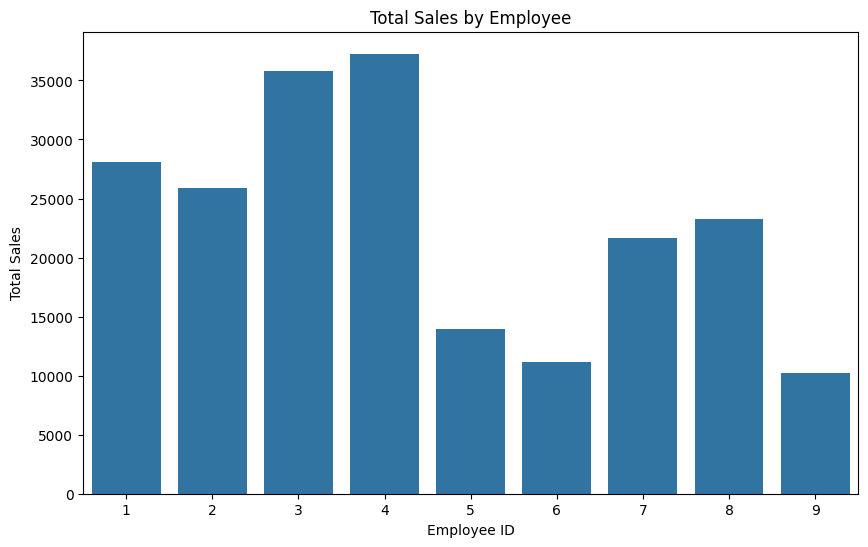

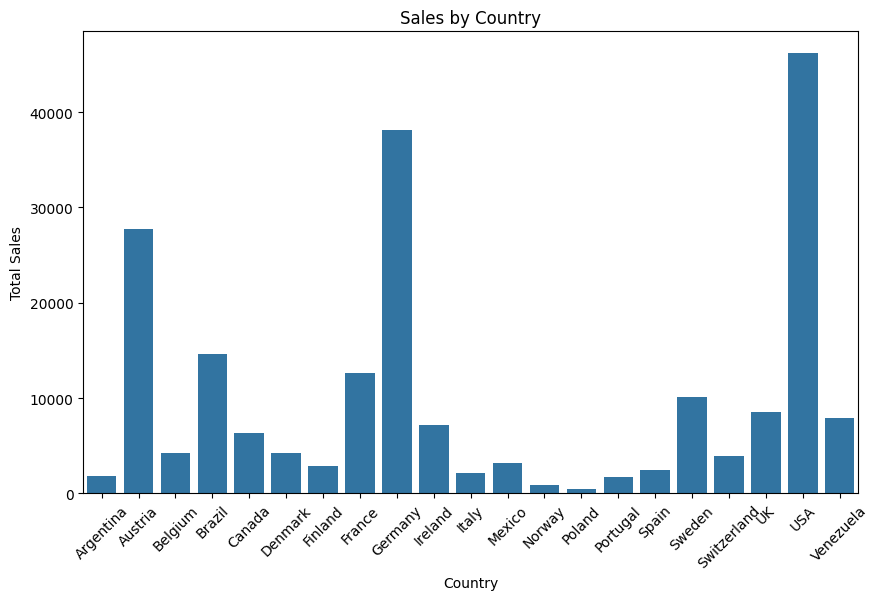

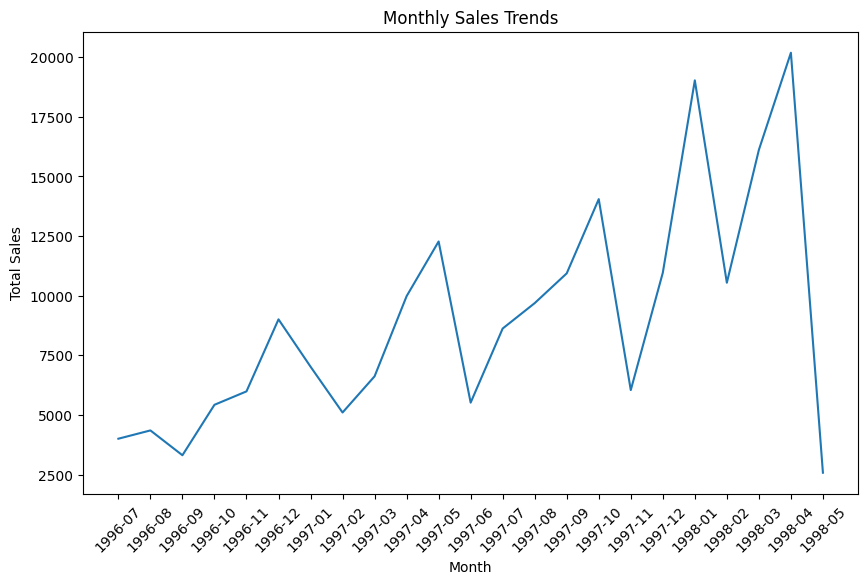

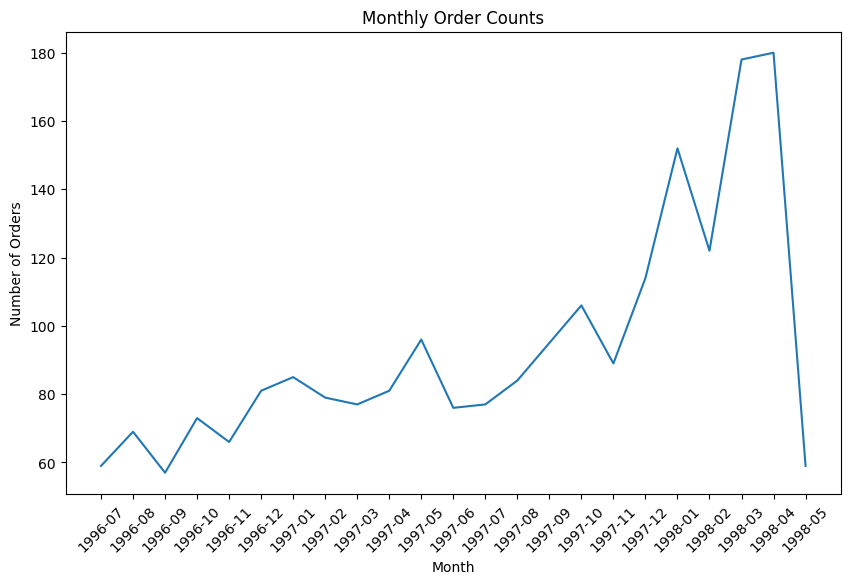

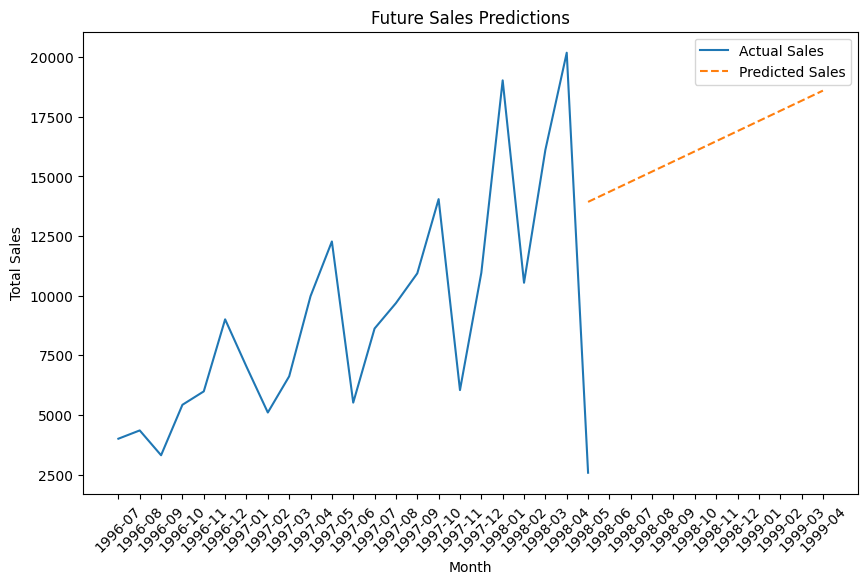

In [53]:
plt.figure(figsize=(10, 6))
sns.barplot(data=total_sales_by_employee, x='Employee ID', y='Total Sales')
plt.xlabel('Employee ID')
plt.ylabel('Total Sales')
plt.title('Total Sales by Employee')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_country, x='Country', y='Total Sales')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.title('Sales by Country')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(monthly_sales_trends['Month'], monthly_sales_trends['Total Sales'])
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trends')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(monthly_order_counts['Month'], monthly_order_counts['Number of Orders'])
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.title('Monthly Order Counts')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(monthly_sales_trends['Month'], monthly_sales_trends['Total Sales'], label='Actual Sales')
plt.plot(future_sales_trends['Month'], future_sales_trends['Predicted Sales'], label='Predicted Sales', linestyle='--')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Future Sales Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.show()

##Passo 6: Recomendações
###Recomendações Baseadas na Análise

1. **Foco nos Funcionários de Alto Desempenho**:
   - Identificar e recompensar os funcionários com maior volume de vendas para manter e incentivar o alto desempenho.
   - Oferecer treinamentos e recursos adicionais para funcionários com desempenho inferior.

2. **Redução da Taxa de Churn**:
   - Implementar programas de fidelidade para incentivar a retenção de clientes.
   - Realizar campanhas de marketing personalizadas para clientes que não realizaram compras recentemente.

3. **Otimização de Estoques**:
   - Utilizar as tendências de vendas mensais para ajustar os níveis de estoque e evitar excesso ou falta de produtos.
   - Monitorar regularmente os níveis de estoque e ajuste as ordens de reposição conforme necessário.

4. **Melhoria da Eficiência da Cadeia de Suprimentos**:
   - Trabalhar de perto com os principais fornecedores para garantir a qualidade e a pontualidade das entregas.
   - Identificar gargalos na cadeia de suprimentos e implemente estratégias para resolvê-los.

5. **Redução dos Custos de Frete**:
   - Negociar com empresas de transporte para obter melhores tarifas e condições.
   - Utilizar métodos de envio mais eficientes e econômicos, como a consolidação de pedidos para reduzir o número de remessas.

6. **Aperfeiçoamento das Estratégias de Vendas e Marketing**:
   - Analisar os padrões de compras dos clientes para desenvolver campanhas de marketing mais eficazes.
   - Utilizar os dados de CLV para segmentar clientes e direcionar esforços de vendas e marketing para os clientes mais valiosos.

7. **Inovações Tecnológicas**:
   - Investir em tecnologia para melhorar a eficiência operacional e a experiência do cliente.
   - Considere a implementação de um sistema de gerenciamento de relacionamento com o cliente (CRM) para acompanhar as interações com os clientes e identificar oportunidades de vendas.

8. **Monitoramento Contínuo**:
   - Estabelecer um painel de controle interativo que permita monitorar os KPIs em tempo real.
   - Realizar análises periódicas para identificar novas oportunidades e ajustar as estratégias conforme necessário.

9. **Expansão Geográfica**:
   - Avaliar a possibilidade de expandir para regiões ou países onde as vendas estão crescendo.
   - Realizar estudos de mercado para identificar novas áreas de crescimento potencial.

10. **Treinamento e Desenvolvimento**:
    - Oferecer programas de treinamento contínuo para desenvolver as habilidades dos funcionários.
    - Promover um ambiente de aprendizado e inovação dentro da empresa.

